# REG Assignment 1

- Sampad Kumar Kar
- MCS202215
- sampadk04@cmi.ac.in

In [1]:
# imports
library(dplyr)
library(caret)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice



In [2]:
# set random seed
set.seed(42)

# P1

## 1.1 Loading the Dataset

In [3]:
data_path <- "data/raw/Bengaluru_House_Data.csv"
df <- read.csv(data_path)

# show the first 6 rows of the data frame
head(df)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<dbl>
1,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2,1,39.07
2,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5,3,120.00
3,Built-up Area,Ready To Move,Uttarahalli,3 BHK,,1440,2,3,62.00
4,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3,1,95.00
5,Super built-up Area,Ready To Move,Kothanur,2 BHK,,1200,2,1,51.00
6,Super built-up Area,Ready To Move,Whitefield,2 BHK,DuenaTa,1170,2,1,38.00


In [4]:
# display the shape of the data frame
dim(df)

[1] 13320     9

So, this dataset has `13320` rows and `9` columns.

In [5]:
# summary of the data frame
summary(df)

  area_type         availability         location             size          
 Length:13320       Length:13320       Length:13320       Length:13320      
 Class :character   Class :character   Class :character   Class :character  
 Mode  :character   Mode  :character   Mode  :character   Mode  :character  
                                                                            
                                                                            
                                                                            
                                                                            
   society           total_sqft             bath           balcony     
 Length:13320       Length:13320       Min.   : 1.000   Min.   :0.000  
 Class :character   Class :character   1st Qu.: 2.000   1st Qu.:1.000  
 Mode  :character   Mode  :character   Median : 2.000   Median :2.000  
                                       Mean   : 2.693   Mean   :1.584  
                        

Amongst the `9` columns, `6` of them are of `character` datatype and remaining `3` are of `numeric` datatype.

The `total_sqft` column should also be numeric, but it is of `character` 
datatype. So, we need to convert it to `numeric` datatype.

## 1.2 Preprocessing

### 1.2.1 Feature Engineering

In [6]:
# check the unique values in the 'size' column
unique(df$size)

[1] "2 BHK"      "4 Bedroom"  "3 BHK"      "4 BHK"      "6 Bedroom" 
 [6] "3 Bedroom"  "1 BHK"      "1 RK"       "1 Bedroom"  "8 Bedroom" 
[11] "2 Bedroom"  "7 Bedroom"  "5 BHK"      "7 BHK"      "6 BHK"     
[16] "5 Bedroom"  "11 BHK"     "9 BHK"      ""           "9 Bedroom" 
[21] "27 BHK"     "10 Bedroom" "11 Bedroom" "10 BHK"     "19 BHK"    
[26] "16 BHK"     "43 Bedroom" "14 BHK"     "8 BHK"      "12 Bedroom"
[31] "13 BHK"     "18 Bedroom"

In [7]:
# make 'size' into a numeric column
df <- df %>%
  mutate(size = case_when(
    grepl("^\\d+ BHK$", size) ~ as.numeric(gsub(" BHK", "", size)),
    grepl("^\\d+ Bedroom$", size) ~ as.numeric(gsub(" Bedroom", "", size)),
    TRUE ~ NA_real_
  ))

Warning message:
"There were 2 warnings in `mutate()`.
The first warning was:
i In argument: `size = case_when(...)`.
Caused by warning:
! NAs introduced by coercion
i Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning."


We make `society` into a binary column, where:
- Assign `1` to the rows where `society` is not empty
- Assign `0` to the rows where `society` is empty

In [8]:
# make 'society' a binary column
df <- df %>%
  mutate(society = ifelse(society != "", 1, 0))

In [9]:
# make 'total_sqft' a numeric column
df <- df %>%
  mutate(total_sqft = case_when(
    # Check if the value is a single integer
    grepl("^\\d+$", total_sqft) ~ as.numeric(total_sqft),

    # Check if the value is a range of integers
    grepl("^\\d+ - \\d+$", total_sqft) ~ {
      # Extract the two integers from the range
      range_values <- as.numeric(strsplit(total_sqft, " - ")[[1]])
      # Calculate the midpoint
      sum(range_values) / 2
    },

    # For unknown values, set them to NA (nan)
    TRUE ~ NA_real_
  ))

Warning message:
"There was 1 warning in `mutate()`.
i In argument: `total_sqft = case_when(...)`.
Caused by warning:
! NAs introduced by coercion"


We can also make `availability` into a binary column, where:
- Assign `1` to the rows where `availability` is `Ready To Move`
- Assign `0` otherwise

In [10]:
# make 'availabiltiy' a binary column
df <- df %>%
  mutate(availability = case_when(
    grepl("Ready To Move", availability) ~ 1,
    TRUE ~ 0
  ))

In [11]:
# dataframe after feature engineering
head(df)

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>
1,Super built-up Area,0,Electronic City Phase II,2,1,1056,2,1,39.07
2,Plot Area,1,Chikka Tirupathi,4,1,2600,5,3,120.00
3,Built-up Area,1,Uttarahalli,3,0,1440,2,3,62.00
4,Super built-up Area,1,Lingadheeranahalli,3,1,1521,3,1,95.00
5,Super built-up Area,1,Kothanur,2,0,1200,2,1,51.00
6,Super built-up Area,1,Whitefield,2,1,1170,2,1,38.00


### 1.2.2 Handling Missing Values

In [12]:
# check for missing values
colSums(is.na(df))

area_type availability     location         size      society   total_sqft 
           0            0            0           29            0          138 
        bath      balcony        price 
          73          609            0

So, we have missing values in the following columns:
- `size`: 29
- `total_sqft`: 138
- `bath`: 73
- `balcony`: 609

Since, all are numerical, we can use `mean` to fill the missing values.

In [13]:
# impute missing values with mean in `total_sqft`, `bath` and `balcony` columns

df$total_sqft[is.na(df$total_sqft)] <- mean(df$total_sqft, na.rm = TRUE)
df$bath[is.na(df$bath)] <- mean(df$bath, na.rm = TRUE)
df$balcony[is.na(df$balcony)] <- mean(df$balcony, na.rm = TRUE)


# drop the remaining rows with missing values
df <- na.omit(df)

# check for missing values again
colSums(is.na(df))

area_type availability     location         size      society   total_sqft 
           0            0            0            0            0            0 
        bath      balcony        price 
           0            0            0

## 1.3 Exploratory Data Analysis

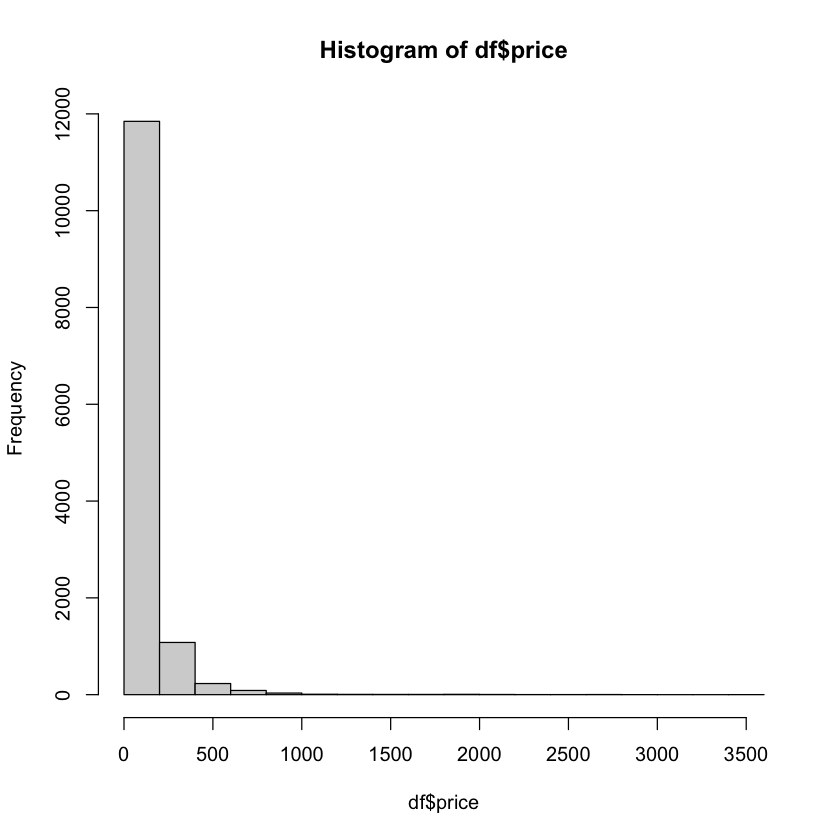

In [14]:
# we plot the distribution of the target variable `price`

hist(df$price)

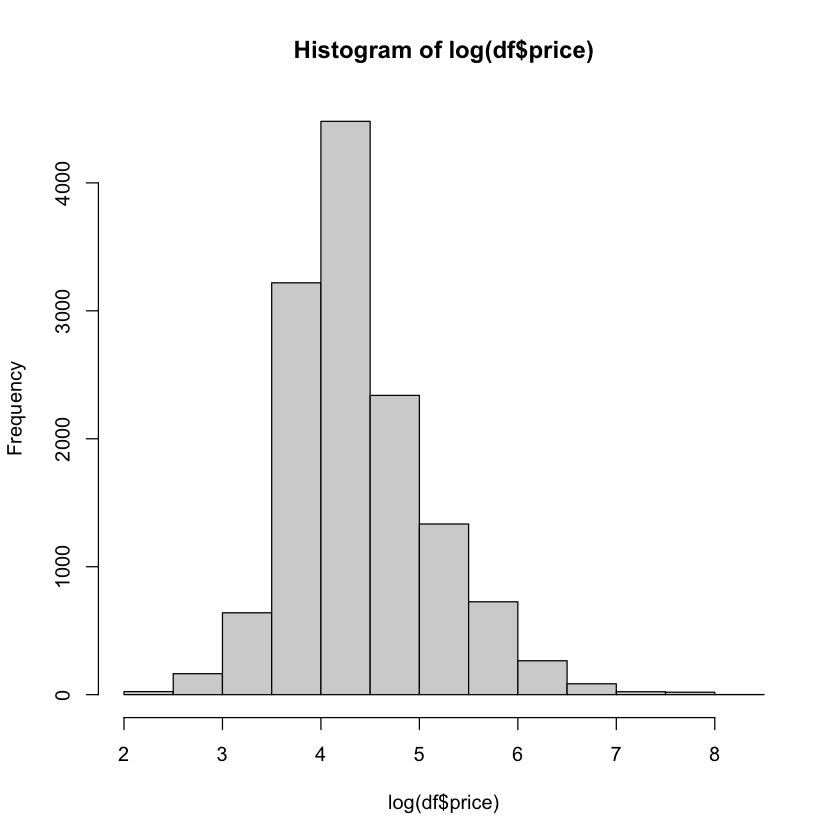

In [15]:
# we plot the distribution of the log(target) variable `log_price`

hist(log(df$price))

As seen from the plots, we can see that, the distribution of target variable `price` seems very skewed. But after applying `log` transformation, it looks more like a normal distribution.

So, we also experiment with the `log` transformed `price` as our target variable.

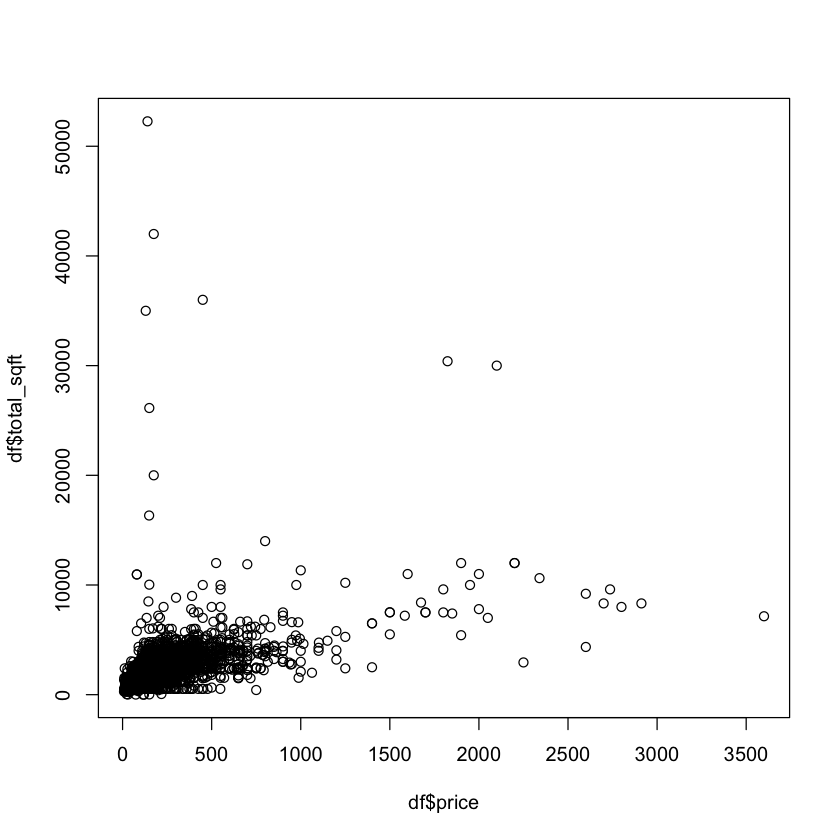

In [16]:
# plot target vs 'total_sqft'

plot(df$price, df$total_sqft)

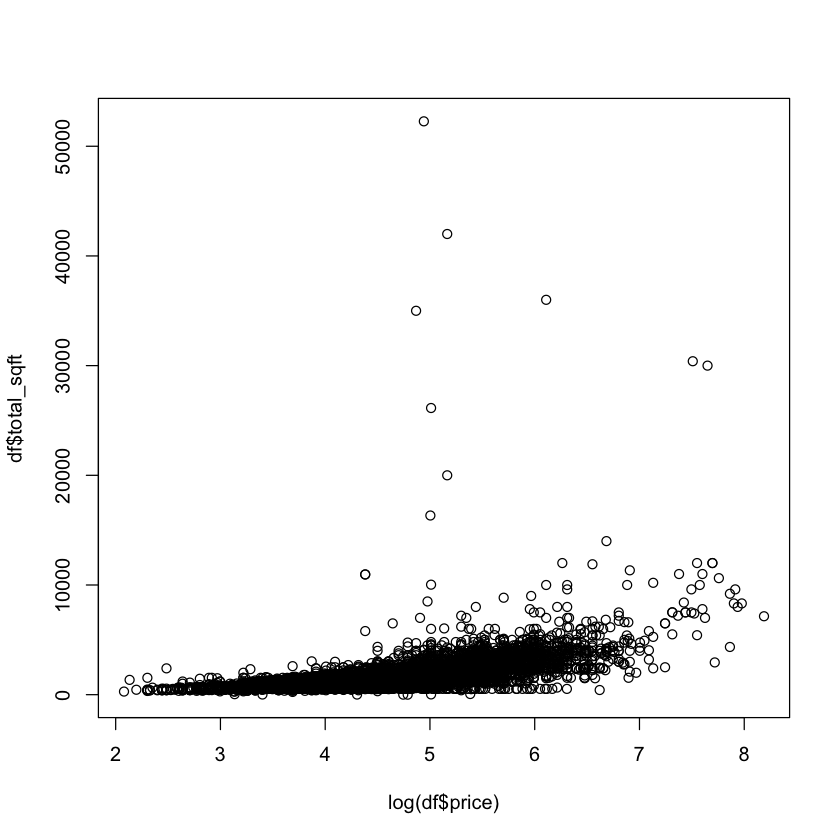

In [17]:
# plot log(target) vs 'total_sqft'

plot(log(df$price), df$total_sqft)

## 1.4 Train Test Split

In [15]:
# train test split
train_indices <- createDataPartition(df$price, p = 0.75, list = FALSE)
train_df <- df[train_indices, ]
test_df <- df[-train_indices, ]

## 1.5 Model Fitting

We use various models to fit the data and compare their performance using `R2` scores.

### 1.5.1 Target: `price`

In [28]:
# this model uses 'size', 'society', 'bath', 'total_sqft' as features and 'price' as target

model_1_1 <- lm(price ~ size + society + bath + total_sqft, data = train_df)
summary(model_1_1)


Call:
lm(formula = price ~ +size + society + bath + total_sqft, data = train_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-2901.46   -30.71   -12.71    10.42  2809.23 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -54.422074   3.414788 -15.937  < 2e-16 ***
size         -7.113568   2.096188  -3.394 0.000693 ***
society     -11.178459   2.409528  -4.639 3.54e-06 ***
bath         32.001607   2.057284  15.555  < 2e-16 ***
total_sqft    0.069974   0.001105  63.323  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 115.2 on 9964 degrees of freedom
Multiple R-squared:  0.4325,	Adjusted R-squared:  0.4323 
F-statistic:  1898 on 4 and 9964 DF,  p-value: < 2.2e-16


In [29]:
# this model uses 'size', 'society', 'bath', 'total_sqft' as well as the square of 'total_sqft' as features and 'price' as target

model_1_2 <- lm(price ~  size + society + bath + total_sqft + I(total_sqft^2), data = train_df)
summary(model_1_2)


Call:
lm(formula = price ~ size + society + bath + total_sqft + I(total_sqft^2), 
    data = train_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1203.70   -31.91    -8.76    18.13  2764.04 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)     -9.062e+01  3.282e+00 -27.607  < 2e-16 ***
size            -4.755e+00  1.941e+00  -2.450   0.0143 *  
society         -1.764e+01  2.236e+00  -7.892 3.29e-15 ***
bath             1.705e+01  1.939e+00   8.794  < 2e-16 ***
total_sqft       1.242e-01  1.676e-03  74.104  < 2e-16 ***
I(total_sqft^2) -2.657e-06  6.505e-08 -40.847  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 106.6 on 9963 degrees of freedom
Multiple R-squared:  0.5139,	Adjusted R-squared:  0.5137 
F-statistic:  2107 on 5 and 9963 DF,  p-value: < 2.2e-16


### 1.5.2 Target: `log(price)`

In [30]:
# this model uses 'size', 'society', 'bath', 'total_sqft' as features and 'log(price)' as target

model_2_1 <- lm(log(price) ~ size + society + bath + total_sqft, data = train_df)
summary(model_2_1)


Call:
lm(formula = log(price) ~ size + society + bath + total_sqft, 
    data = train_df)

Residuals:
     Min       1Q   Median       3Q      Max 
-10.8015  -0.2927  -0.0348   0.2533   2.8373 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) 3.322e+00  1.494e-02 222.398  < 2e-16 ***
size        5.263e-02  9.169e-03   5.741  9.7e-09 ***
society     2.342e-02  1.054e-02   2.222   0.0263 *  
bath        1.942e-01  8.998e-03  21.576  < 2e-16 ***
total_sqft  2.528e-04  4.833e-06  52.303  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.504 on 9964 degrees of freedom
Multiple R-squared:  0.512,	Adjusted R-squared:  0.5118 
F-statistic:  2613 on 4 and 9964 DF,  p-value: < 2.2e-16


In [31]:
# this model uses 'size', 'society', 'bath', 'total_sqft' as well as the square of 'total_sqft' as features and 'price' as target

model_2_2 <- lm(log(price) ~ size + society + bath + total_sqft + I(total_sqft^2), data = train_df)
summary(model_2_2)


Call:
lm(formula = log(price) ~ size + society + bath + total_sqft + 
    I(total_sqft^2), data = train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-5.9864 -0.2693 -0.0294  0.2300  2.5579 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.134e+00  1.385e-02 226.230  < 2e-16 ***
size             6.490e-02  8.190e-03   7.924 2.54e-15 ***
society         -1.020e-02  9.434e-03  -1.081     0.28    
bath             1.164e-01  8.182e-03  14.228  < 2e-16 ***
total_sqft       5.350e-04  7.074e-06  75.621  < 2e-16 ***
I(total_sqft^2) -1.382e-08  2.745e-10 -50.340  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.45 on 9963 degrees of freedom
Multiple R-squared:  0.6109,	Adjusted R-squared:  0.6107 
F-statistic:  3129 on 5 and 9963 DF,  p-value: < 2.2e-16


In [46]:
# this model uses 'size', 'society', 'bath', 'total_sqft' as well as the cube of 'total_sqft' as features and 'price' as target

model_2_3 <- lm(log(price) ~ size + society + bath + total_sqft + I(total_sqft^3), data = train_df)
summary(model_2_3)


Call:
lm(formula = log(price) ~ size + society + bath + total_sqft + 
    I(total_sqft^3), data = train_df)

Residuals:
    Min      1Q  Median      3Q     Max 
-6.3325 -0.2734 -0.0266  0.2374  3.1772 

Coefficients:
                  Estimate Std. Error t value Pr(>|t|)    
(Intercept)      3.211e+00  1.388e-02 231.382  < 2e-16 ***
size             6.588e-02  8.384e-03   7.858 4.31e-15 ***
society          5.704e-07  9.646e-03   0.000        1    
bath             1.296e-01  8.351e-03  15.518  < 2e-16 ***
total_sqft       4.283e-04  5.928e-06  72.237  < 2e-16 ***
I(total_sqft^3) -2.813e-13  6.340e-15 -44.369  < 2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.4606 on 9963 degrees of freedom
Multiple R-squared:  0.5925,	Adjusted R-squared:  0.5923 
F-statistic:  2897 on 5 and 9963 DF,  p-value: < 2.2e-16


# P2


We obtained the following results:

| Model | Target | Adj R2 Score |
| --- | --- | --- |
| model_1_1 | `price` | `0.4323` |
| model_1_2 | `price` | `0.5137` |
| model_2_1 | `log(price)` | `0.5118` |
| model_2_2 | `log(price)` | `0.6107` |
| model_2_3 | `log(price)` | `0.5923` |

Based on the above results, we can say that `model_2_3`, which fits the data with `log(price)` as the target variable against `size`, `society`, `total_sqft`, `bath` and `total_sqft^3` as the features is the best.

This can be attributed to the following reasons:
- It obtains a respectable `Adj R2` score of `0.5923`
- It has a low Residual Standard Error.
- The coefficients of the features are also interpretable (the are positive, which matched the intuition corresponding to housing prices).

# P3

## 3.a

In [47]:
data_3a_1 <- data.frame(total_sqft = 2000, size = 3, bath = 2, society = 1)
data_3a_2 <- data.frame(total_sqft = 2000, size = 3, bath = 2, society = 0)

# predict the price for the two data points
price_3a_1 <- exp(predict(model_2_3, data_3a_1))
price_3a_2 <- exp(predict(model_2_3, data_3a_2))

# the builder should expect the following as premiuim for society:
price_3a_1 - price_3a_2

1 
5.24848e-05

## 3.b

In [54]:
data_3b_1 <- data.frame(total_sqft = 3000, size = 5, bath = 4, society = 1)
data_3b_2 <- data.frame(total_sqft = 3000, size = 5, bath = 4, society = 0)

# predict the price for the two data points
price_3b_1 <- exp(predict(model_2_3, data_3b_1))
price_3b_2<- exp(predict(model_2_3, data_3b_2))

# the builder should expect the following as premiuim for society:
price_3b_1 - price_3b_2

1 
2.256559

## 3.c

In [55]:
data_3c_1 = data.frame(total_sqft = 2000, size = 3, bath = 3, society = 1)
data_3c_2 = data.frame(total_sqft = 2000, size = 3, bath = 4, society = 1)

# predict the price for the two data points
price_3c_1 <- exp(predict(model_2_3, data_3c_1))
price_3c_2 <- exp(predict(model_2_3, data_3c_2))

# the builder should expect the following as premiuim for 4 bathrooms over 3 bathrooms:
price_3c_1 - price_3c_2

1 
14.49203

## 3.d

In [57]:
data_3d_1 = data.frame(total_sqft = 1500, size = 2, bath = 2, society = 1)
data_3d_2 = data.frame(total_sqft = 1500, size = 3, bath = 2, society = 1)

# predict the price for the two data points
price_3d_1 <- exp(predict(model_2_3, data_3d_1))
price_3d_2 <- exp(predict(model_2_3, data_3d_2))

# the builder should expect the following as premiuim for 3 BHK over 2 BHK:
price_3d_1 - price_3d_2

1 
4.741597